In [13]:
from multicartpole import get_urdf, get_lqr_diagram, simulate_diagram

from pydrake.all import DiagramBuilder, SceneGraph, MultibodyPlant, Parser, Linearize, ControllabilityMatrix, PlanarSceneGraphVisualizer, MultibodyPositionToGeometryPose

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

from IPython.display import HTML, display

from tqdm import tqdm

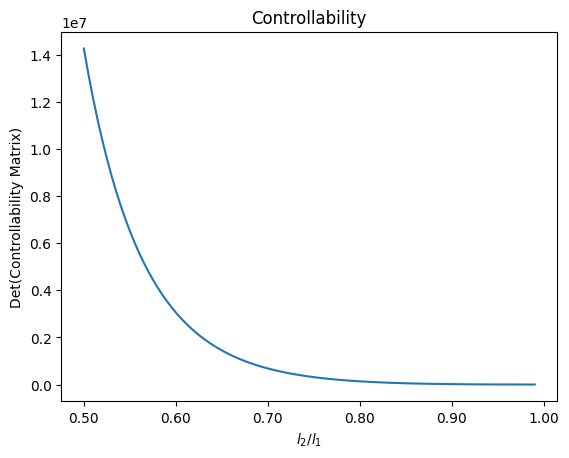

In [2]:
dets = []

l1 = 1
n = 101
l2s = np.linspace(0.5,0.99, 98)

for l2 in l2s:
    urdf = get_urdf(2, [l1, l2])

    builder = DiagramBuilder()
    scene_graph = SceneGraph()

    plant = MultibodyPlant(time_step=0.0)
    builder.AddSystem(scene_graph)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()

    x_star = np.zeros(6)
    plant_context = plant.CreateDefaultContext()
    plant.SetPositionsAndVelocities(plant_context, x_star)
    plant.get_actuation_input_port().FixValue(plant_context, [0])
    linear_plant = Linearize(plant, plant_context, plant.get_actuation_input_port().get_index(), plant.get_state_output_port().get_index())
    controllability = ControllabilityMatrix(linear_plant)
    dets.append(np.linalg.det(controllability))

plt.title("Controllability")
from matplotlib.ticker import StrMethodFormatter
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("$l_2/l_1$")
plt.ylabel("Det(Controllability Matrix)")
plt.plot(l2s, dets)

In [3]:
x_lim = 5

l1 = 1
n = 100
x1_lim = (0.01,0.99)
x2_lim = (0, 0.4)
l2s = np.linspace(*x1_lim,n)
x0s = np.linspace(*x2_lim, n)

roa = np.zeros((n,n))

for i in tqdm(range(n)):
    urdf = get_urdf(2, [l1, l2s[i]])

    diagram = get_lqr_diagram(urdf, 2)
    logger = diagram.GetSubsystemByName("logger")

    for j in range(n):
        try:
            x0 = np.array([0,x0s[j],0,0,0,0])
            context = simulate_diagram(diagram, x0, 5)
            log = logger.FindLog(context)
            
            if np.max(np.abs(log.data()[0,:])) < x_lim and np.max(np.abs(log.data()[1:3,:])) < np.pi/2:
                roa[n-j-1,i] = np.max(np.abs(log.data()[0,:]))
        except: # unstable
            pass

100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


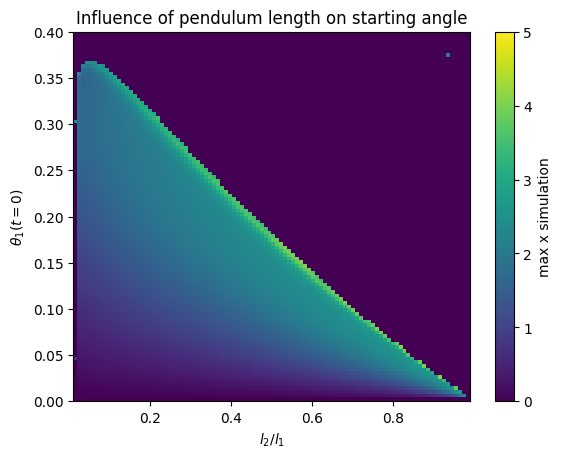

In [4]:
plt.title("Influence of pendulum length on starting angle")

plt.xlabel("$l_2/l_1$")
plt.ylabel("$\\theta_1(t = 0)$")

im = plt.imshow(roa, aspect="auto", extent=[*x1_lim, *x2_lim], vmin=0, vmax=x_lim)
plt.colorbar(im, label = "max x simulation")

In [7]:
x_lim = 5

l1 = 1
n = 100
x1_lim = (0.01,0.99)
x2_lim = (0, 1)
l2s = np.linspace(*x1_lim,n)
x0s = np.linspace(*x2_lim, n)

roa = np.zeros((n,n))

for i in tqdm(range(n)):
    urdf = get_urdf(2, [l1, l2s[i]])

    diagram = get_lqr_diagram(urdf, 2)
    logger = diagram.GetSubsystemByName("logger")

    for j in range(n):
        try:
            x0 = np.array([0,0,x0s[j],0,0,0])
            context = simulate_diagram(diagram, x0, 5)
            log = logger.FindLog(context)
            
            if np.max(np.abs(log.data()[0,:])) < x_lim and np.max(np.abs(log.data()[1:3,:])) < np.pi/2:
                roa[n-j-1,i] = np.max(np.abs(log.data()[0,:]))
        except: # unstable
            pass

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


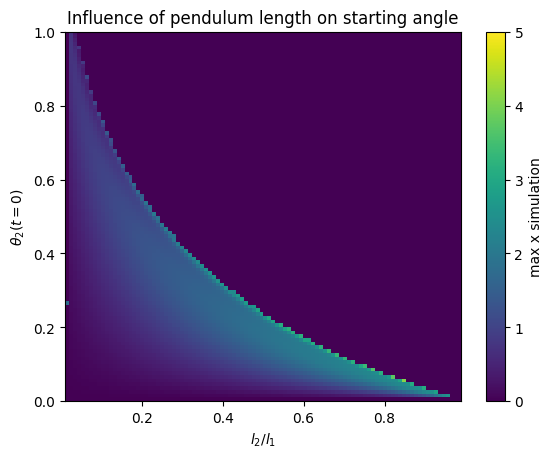

In [8]:
plt.title("Influence of pendulum length on starting angle")

plt.xlabel("$l_2/l_1$")
plt.ylabel("$\\theta_2(t = 0)$")

im = plt.imshow(roa, aspect="auto", extent=[*x1_lim, *x2_lim], vmin=0, vmax=x_lim)
plt.colorbar(im, label = "max x simulation")

In [9]:
x_lim = 5
l1 = 1
n = 101

l2s = np.linspace(0.02,0.99, 98)

th1 = np.linspace(-1, 1, n)
th2 = np.linspace(-1, 1, n)


for l2i, l2 in tqdm(enumerate(l2s)):
    roa = -np.ones((n,n))

    urdf = get_urdf(2, [l1, l2])

    diagram = get_lqr_diagram(urdf, 2)
    logger = diagram.GetSubsystemByName("logger")

    for i in range(int(n/2+1)):
        for j in range(n):

            try:
                
                x0 = np.array([0,th1[i],th2[j],0,0,0])

                context = simulate_diagram(diagram, x0, 5)

                log = logger.FindLog(context)
                
                if np.max(np.abs(log.data()[0,:])) < x_lim and np.max(np.abs(log.data()[1:3,:])) < np.pi/2: 
                    roa[n-j-1,i] = np.max(np.abs(log.data()[0,:]))
                    roa[j,n-i-1] = np.max(np.abs(log.data()[0,:]))
            except: # unstable
                continue
    np.save(f"roa/roa_{l2i}", roa)
        

98it [18:02, 11.04s/it]


In [14]:
x_lim = 5
l2s = np.linspace(0.02,0.99, 98)
n = 101

roa = np.zeros((n,n))

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
fig.suptitle("Double pendulum")
fig.set_figwidth(20)

plt.subplots_adjust(bottom=0.15)

im = ax1.imshow(roa, extent=[-1,1,-1,1], vmin=-1, vmax=x_lim)

plt.colorbar(im, label = 'max x simulation')

ax1.set_xlabel('$\\theta_0$ [rad]')
ax1.set_ylabel('$\\theta_1$ [rad]')

def animate(i):
    roa = np.load(f"roa/roa_{i}.npy")
    im.set_data(roa)

    ax2.clear()

    urdf = get_urdf(2, l_pend=[1,l2s[i]])
    scene_graph = SceneGraph()
    plant = MultibodyPlant(time_step=0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    visualizer = PlanarSceneGraphVisualizer(scene_graph, xlim=[-0.35,0.35], ylim=[0.35, 0.7], show=False, ax=ax2)
    pos_to_pose = MultibodyPositionToGeometryPose(plant, input_multibody_state=True)

    ptp_context = pos_to_pose.CreateDefaultContext()
    pos_to_pose.get_input_port().FixValue(ptp_context, [0]*6)
    frame_pose_vector = pos_to_pose.get_output_port().Eval(ptp_context)

    sg_context = scene_graph.CreateDefaultContext()
    scene_graph.get_source_pose_port(plant.get_source_id()).FixValue(sg_context, frame_pose_vector)
    query = scene_graph.get_query_output_port().Eval(sg_context)

    v_context = visualizer.CreateDefaultContext()
    
    visualizer.get_geometry_query_input_port().FixValue(v_context, query)
    visualizer.draw(v_context)

    ax2.title.set_text('$l_2/l_1 = {:.2f}$'.format(l2s[i]))
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(l2s))
plt.close()

display(HTML(ani.to_jshtml()))

In [16]:
x_lim = 1
l_max = 1

urdf = get_urdf(2, l_pend=[1,0.8])

diagram = get_lqr_diagram(urdf, 2, xlim=[-x_lim - l_max, x_lim + l_max], ylim=[-0.2, l_max+0.5])

visualizer = diagram.GetSubsystemByName("visualizer")

visualizer.start_recording()

x0 = np.array([0,0.95,-0.24,0,0,0])
context = simulate_diagram(diagram, x0, 5)

ani = visualizer.get_recording_as_animation()
display(HTML(ani.to_jshtml()))